In [67]:
# Imports
from lib.utils import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn.functional import relu,one_hot,softmax
from tqdm import tqdm
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

device = 'cuda'
torch.cuda.empty_cache()

In [68]:
X,y = load_raw_list(range(20,25))
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,shuffle=True,stratify=y,random_state=0)

In [69]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [70]:
X_train = torch.from_numpy(X_train_res)
y_train = torch.from_numpy(y_train_res)

In [71]:
X_train = X_train.reshape(-1,1,5000)
X_test = X_test.reshape(-1,1,5000)
y_train_one_hot = one_hot(y_train,num_classes=3).reshape(-1,3).float()
y_test_one_hot = one_hot(y_test,num_classes=3).reshape(-1,3).float()
train_dataloader = DataLoader(TensorDataset(X_train,y_train_one_hot), batch_size=32, shuffle=True)
test_dataloader = DataLoader(TensorDataset(X_test,y_test_one_hot), batch_size=32, shuffle=False)

In [77]:
class CNN_0(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.c1 = nn.Conv1d(1, 16, kernel_size=500, stride=10)
        self.c2 = nn.Conv1d(16, 8, kernel_size=20, stride=1)
        self.fc1 = nn.Linear(824, 3)
        self.fc1.bias = torch.nn.Parameter(data=torch.Tensor([.1,1,1]))

    def forward(self,x):
        x = self.c1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool1d(x, kernel_size=2)
        x = self.c2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool1d(x, kernel_size=2)
        x = nn.Flatten()(x)
        x = self.fc1(x)
        
        return x

In [78]:
model = CNN_0().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
train_losses = []
test_losses = []

In [79]:
training_loss = 0
model.train()
for (X,y) in train_dataloader:
    X,y = X.to(device), y.to(device)
    logits = model(X)
    loss = criterion(logits,y)
    training_loss += loss.item()
training_loss/len(train_dataloader)

1.1781594491821235

In [81]:
for epoch in range(20):
    training_loss = 0
    model.train()
    for (X,y) in train_dataloader:
        X,y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    train_losses.append(training_loss/len(train_dataloader))
    model.eval()
    testing_loss = 0
    for (X,y) in test_dataloader:
        X,y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits,y)
        testing_loss += loss.item()
    test_losses.append(testing_loss/len(test_dataloader))
    print(f'Epoch {epoch} Train: {training_loss/len(train_dataloader)} Test: {testing_loss/len(test_dataloader)}')
    plt.plot(train_losses[-300:],label='train')
    plt.plot(test_losses[-300:],label='validation')
    plt.savefig('loss.jpg',dpi=200)
    plt.close()

Epoch 0 Train: 0.3314802860239526 Test: 0.3645931956392747
Epoch 1 Train: 0.3227877121187689 Test: 0.3898814143957915
Epoch 2 Train: 0.31527304284765506 Test: 0.34213425566752753
Epoch 3 Train: 0.30931850252745224 Test: 0.3875663678403254
Epoch 4 Train: 0.3058831128761057 Test: 0.32280436116788125
Epoch 5 Train: 0.30301143119511137 Test: 0.3386242826227789
Epoch 6 Train: 0.30439422988556614 Test: 0.3466271889430505
Epoch 7 Train: 0.299196082973511 Test: 0.3359852782554097
Epoch 8 Train: 0.30195729067255517 Test: 0.3784579833900487
Epoch 9 Train: 0.2975768228193856 Test: 0.341239948819081
Epoch 10 Train: 0.2959311669957114 Test: 0.3776815508250837
Epoch 11 Train: 0.29353121673876004 Test: 0.3564238396231775
Epoch 12 Train: 0.29801971042764586 Test: 0.3554411506763211
Epoch 13 Train: 0.2924024844975319 Test: 0.4102727264717773
Epoch 14 Train: 0.28919421162850945 Test: 0.3173105579007555
Epoch 15 Train: 0.2902992069384309 Test: 0.3817742734595581
Epoch 16 Train: 0.28519376004668245 Test: 

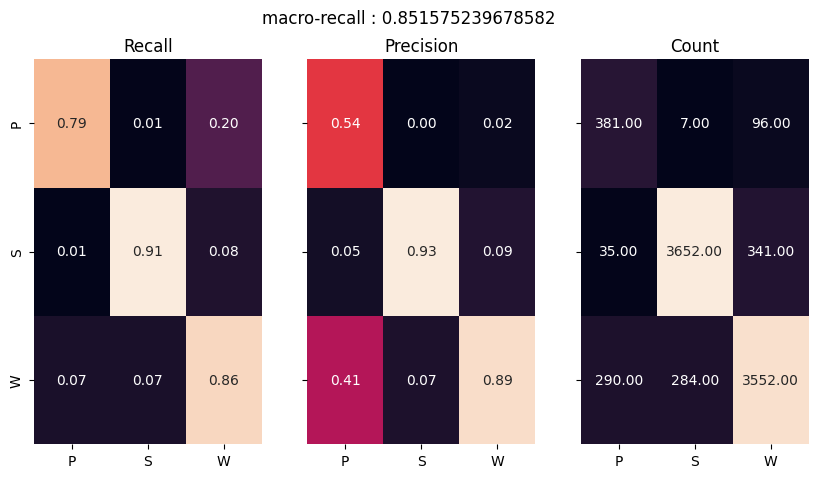

In [82]:
y_pred = torch.Tensor().cuda()
for (X,_) in test_dataloader:
    y_pred = torch.cat([y_pred,softmax(model(X.cuda()),dim=1).argmax(axis=1)])
y_pred = y_pred.cpu()

cms(y_true=y_test,y_pred=y_pred)

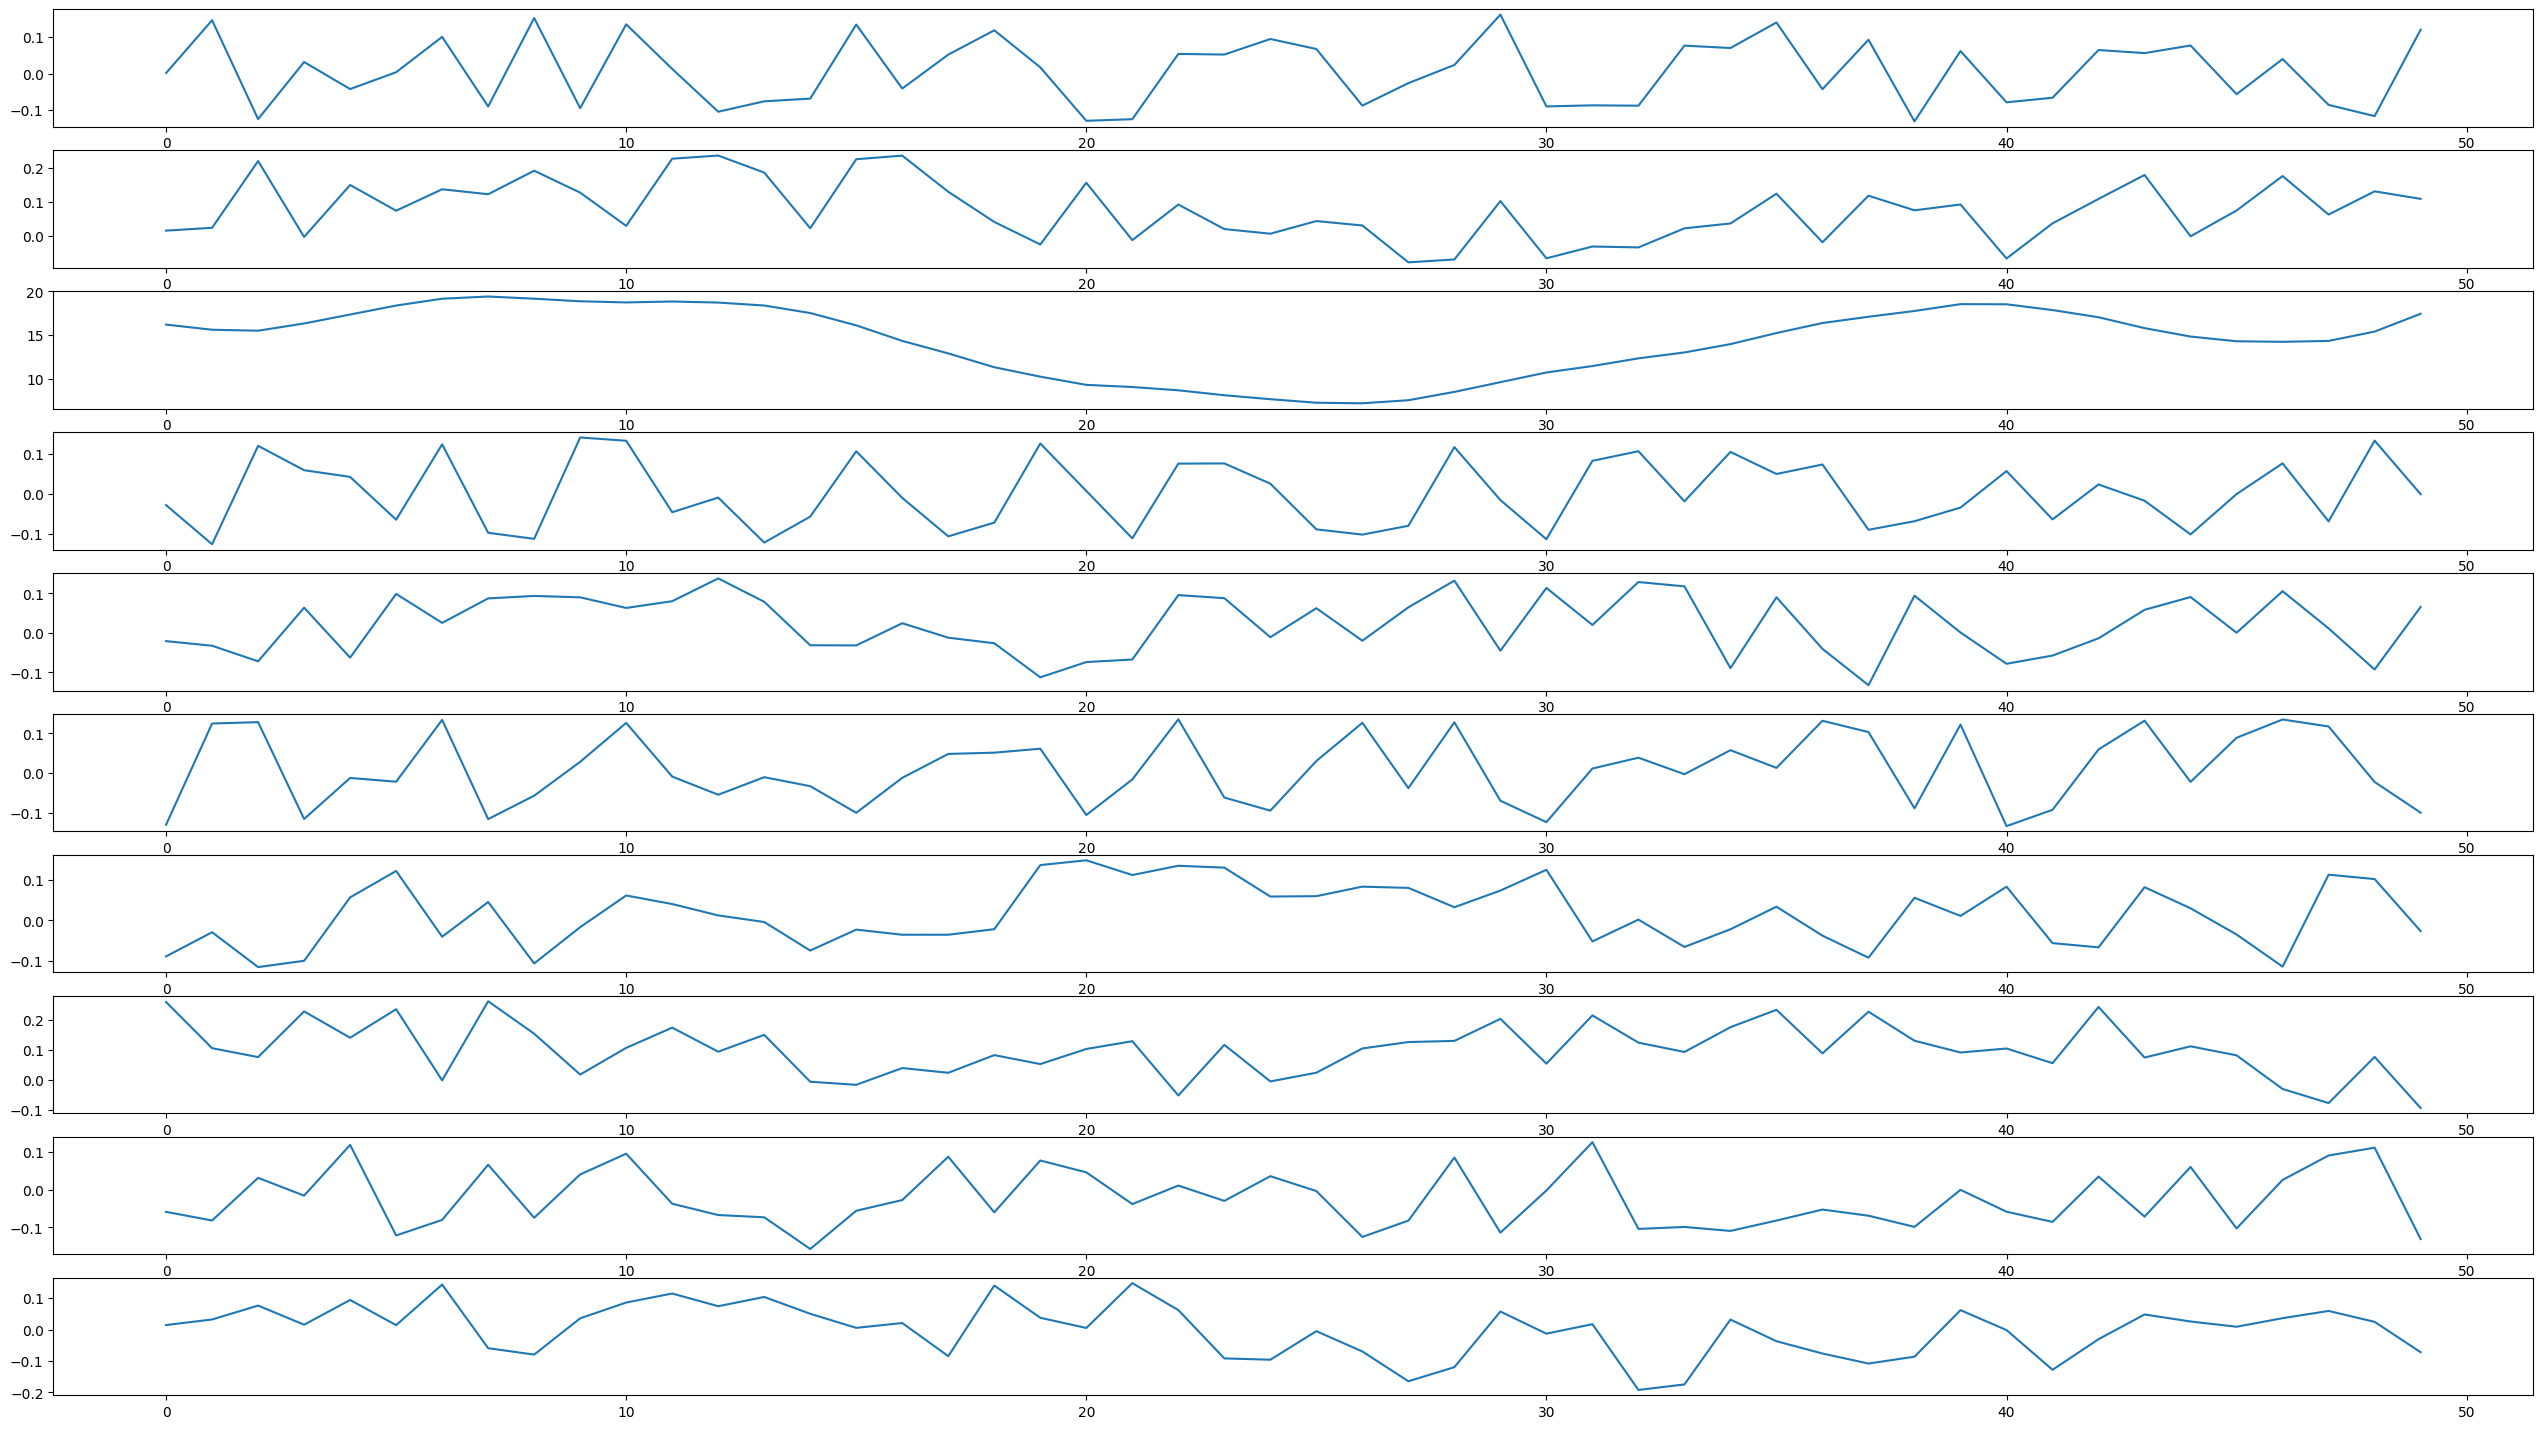

In [57]:
fig,axes = plt.subplots(nrows=len(model.c1.weight),ncols=1,figsize=(32,18))
for i in range(len(model.c1.weight)):
    axes[i].plot(model.c1.weight[i].squeeze().detach().cpu())
plt.savefig('figures/kernels.jpg',dpi=500)

In [53]:
torch.save(obj=model.state_dict(),f='model.pt')